In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
import scipy.special as ssp
import sys
import scipy.io as sio
sys.path.append("../code/")
from pi_vae import *
from util import *
from keras.callbacks import ModelCheckpoint

## import plot packages
from matplotlib.ticker import FormatStrFormatter
from matplotlib import ticker

%load_ext autoreload
%autoreload 2
%matplotlib inline

## load macaque data

In [2]:
## load trial information
## starttime, endtime, number, tgtontime, gocuetime, tgtdir, tgtid
trial_dat = sio.loadmat("../data/chewie_data/Chewie_20161006_trials_array.mat")

In [3]:
## load spike data
dat_ = sio.loadmat('../data/chewie_data/Chewie_20161006_seq.mat');

dat_all = [[] for _ in range(8)];
tar_dir = np.unique(trial_dat['trials_array'][:,5])[:8];
trial_dat_id = np.unique(trial_dat['trials_array'][:,5],return_inverse=True)[1];

for trial_id in range(251):
    if dat_['seq'][0][trial_id]['T'][0,0] != 0:
        dat_all[trial_dat_id[trial_id]].append(dat_['seq'][0][trial_id]['y'].T[:,63:]);

dat_all = np.array([np.array(dat_all[ii]) for ii in range(8)]);

In [4]:
## randomly split into batches
np.random.seed(666);
trial_ls = [np.random.permutation(np.array_split(np.random.permutation(np.arange(dat_all[ii].shape[0])),24)) for ii in range(8)];

x_all = [];
u_all = [];
for ii in range(24): # 24 batches
    x_tr = [];
    u_tr = [];
    for jj in range(8): # 8 different directions
        x_tmp = np.concatenate(dat_all[jj][trial_ls[jj][ii]])#[:,:-1];
        u_tmp = np.ones((x_tmp.shape[0],1))*jj;
        x_tr.append(x_tmp);
        u_tr.append(u_tmp);
    x_all.append(np.concatenate(x_tr));
    u_all.append(np.concatenate(u_tr));

x_all = np.array(x_all);
u_all = np.array(u_all);

In [5]:
x_train = x_all[:20];
u_train = u_all[:20];

x_valid = x_all[20:22];
u_valid = u_all[20:22];

x_test = x_all[22:];
u_test = u_all[22:];

In [6]:
## check pca results
from sklearn.decomposition import PCA
pca_raw = PCA(n_components=x_all[0].shape[-1]);
pca_raw_rlt = pca_raw.fit_transform(np.concatenate(x_all));

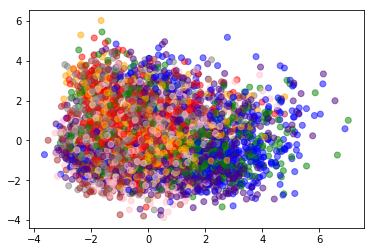

In [7]:
## plot pca results
c_vec = np.array(['red','orange','green','blue','indigo','pink','brown','gray'])
c_all = c_vec[np.array(np.concatenate(u_all)[:,0]%8, dtype='int')];
plt.scatter(pca_raw_rlt[:,0], pca_raw_rlt[:,1], c=c_all, alpha=0.5)

## fit pi-vae

In [8]:
vae = vae_mdl(dim_x=x_all[0].shape[-1],
                   dim_z=4,
                   dim_u=np.unique(np.concatenate(u_all)).shape[0],
                   gen_nodes=60, n_blk=2, mdl='poisson', disc=True, learning_rate=5e-4)

Instructions for updating:
Colocations handled automatically by placer.
Model: "vae"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 192)          0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
encoder (Model)                 [(None, 4), (None, 4 31032       input_1[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
decoder (Model)         

/home/dz2336/anaconda3/lib/python3.6/site-packages/keras/engine/training_utils.py:819: UserWarning: Output encoder missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to encoder.
  'be expecting any data to be passed to {0}.'.format(name))
/home/dz2336/anaconda3/lib/python3.6/site-packages/keras/engine/training_utils.py:819: UserWarning: Output decoder missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to decoder.
  'be expecting any data to be passed to {0}.'.format(name))


# use pi-vae_macaque_data_try_different_random_seed.py to run all the random seeds and load the results to check here

In [9]:
seed_vec = [111,222,333,444,555,666,777,888,999,1000,1100,1200]
elbo_samples_all = np.zeros((100, len(seed_vec)))
for i in range(len(seed_vec)):
    seed_use = seed_vec[i]
    elbo_samples_all[:,i] = np.load('../results/macaque_4d_'+str(seed_use)+'_pivae_elbo_samples.npy')

Text(0.5,0,'random seeds')

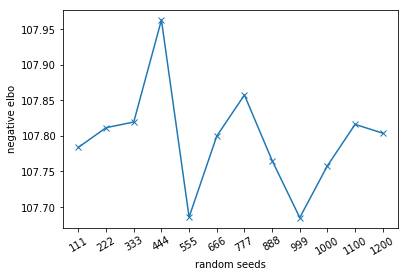

In [10]:
plt.plot(elbo_samples_all.mean(axis=0),'-x')
plt.xticks(np.arange(len(seed_vec)), seed_vec, rotation = 30);
plt.ylabel('negative elbo')
plt.xlabel('random seeds')

/home/dz2336/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


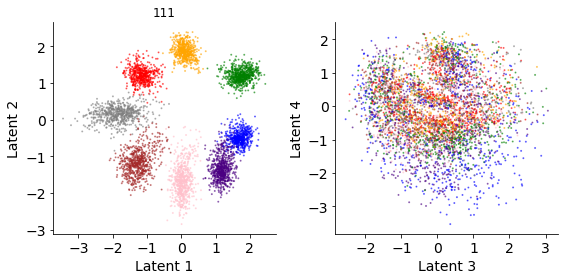

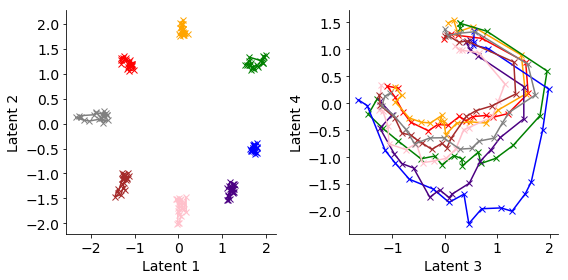

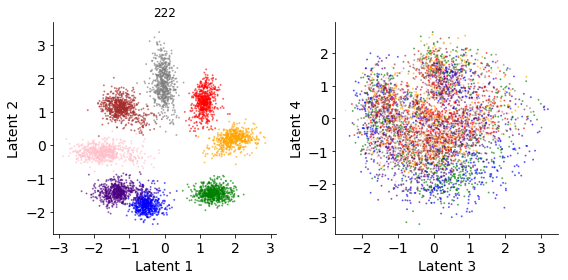

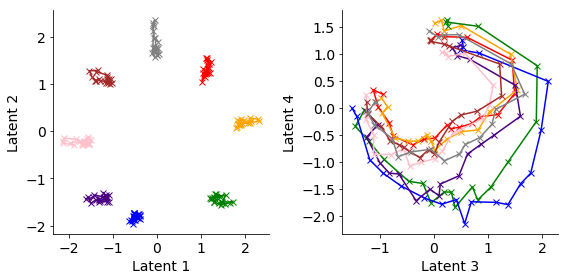

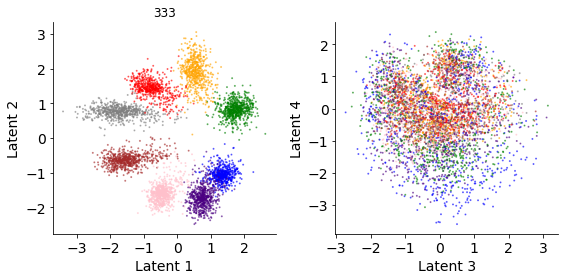

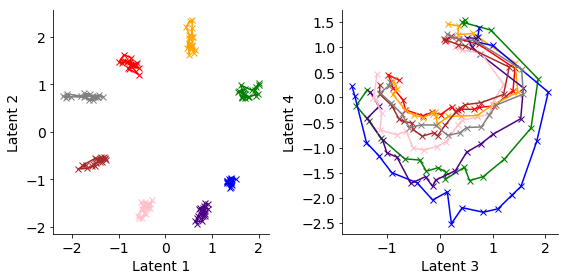

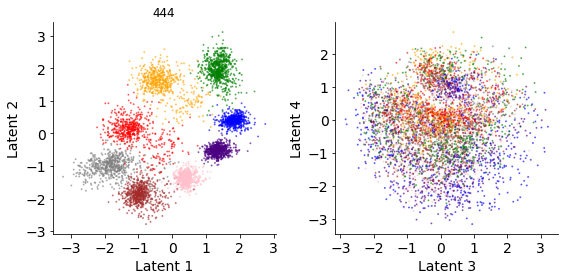

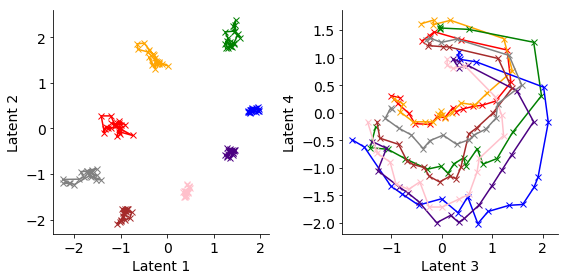

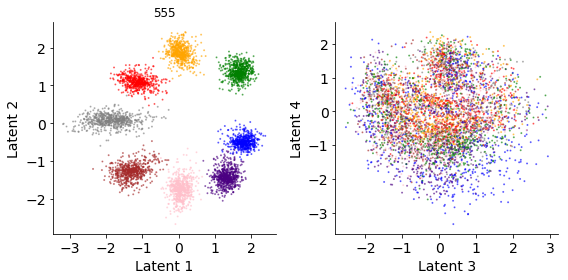

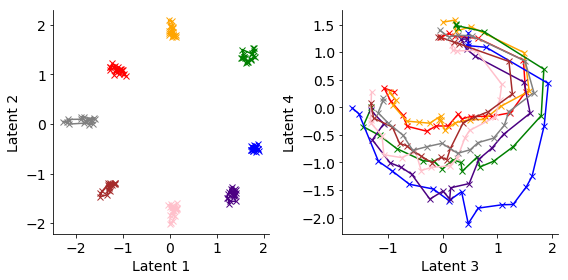

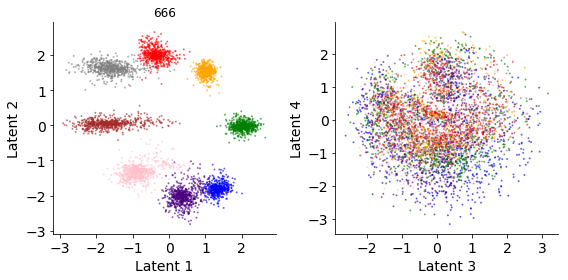

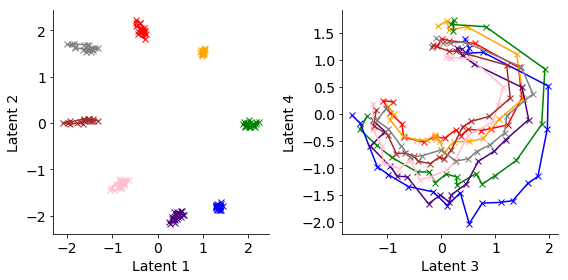

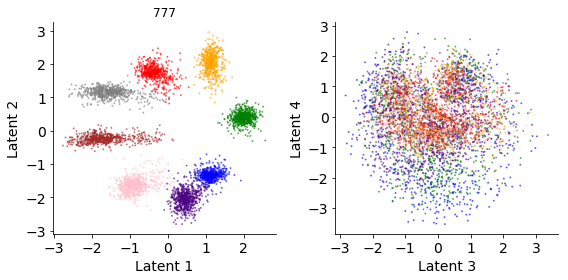

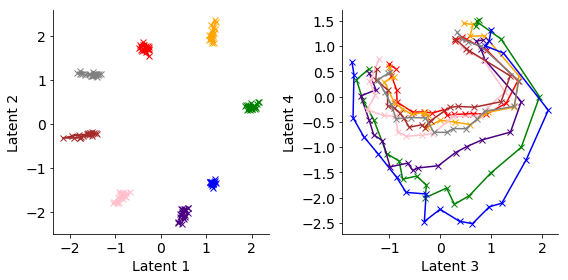

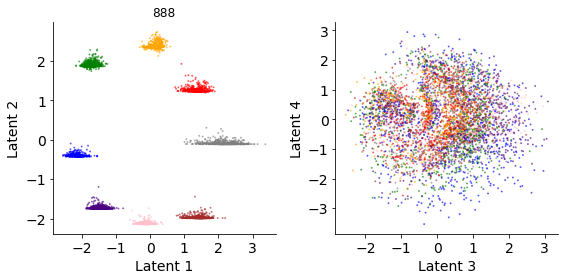

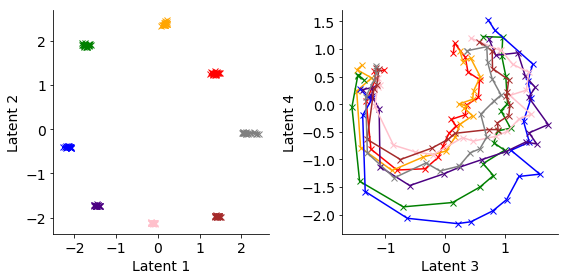

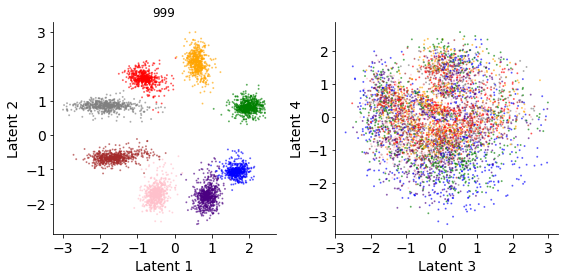

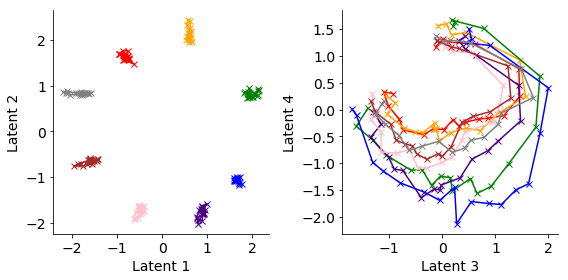

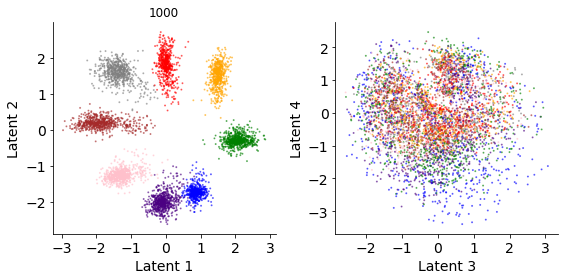

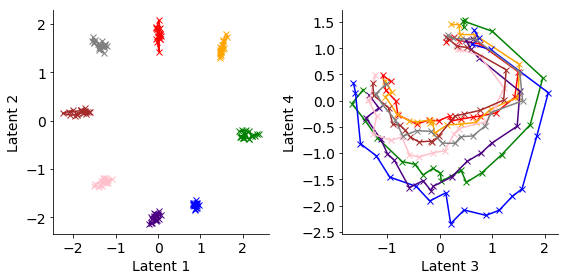

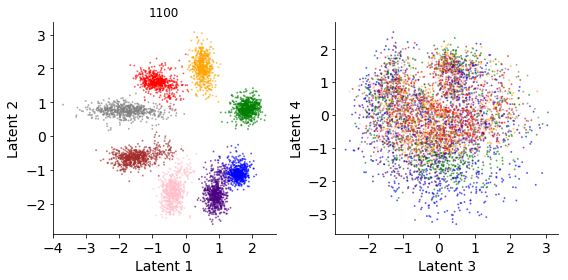

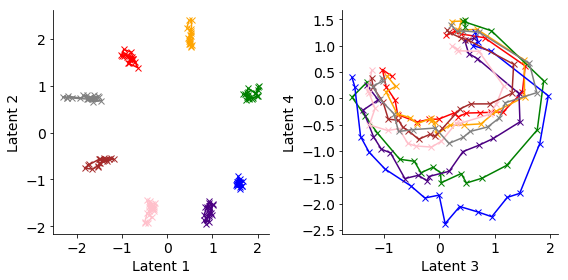

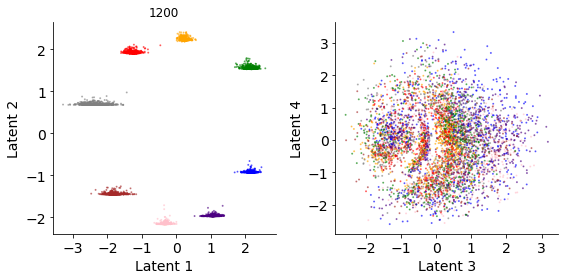

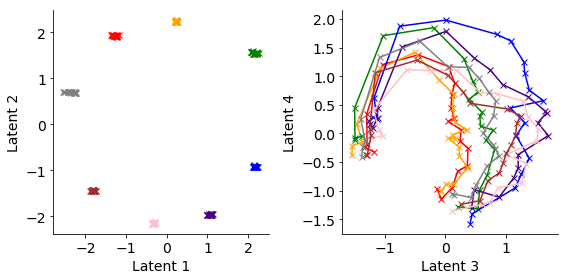

In [11]:
seed_vec = [111,222,333,444,555,666,777,888,999,1000,1100,1200]
for i in range(len(seed_vec)):
    seed_use = seed_vec[i]
    np.random.seed(seed_use);
    first_pair = [3,1]
    second_pair = [2,0]
    if seed_use == 888 or seed_use == 1200:
        first_pair = [1,2]
        second_pair = [3,0]
    
    model_chk_path = '../results/macaque_4d_'+str(seed_use)+'_pivae.h5' ##999, 777
    vae.load_weights(model_chk_path);
    outputs = vae.predict_generator(custom_data_generator(x_all, u_all),
                                                steps = len(x_all));
    z_pred_all = [];
    for ii in range(dat_all.shape[0]):
        z_pred_tmp = [];
        for jj in range(dat_all[ii].shape[0]):
            z_pred_tmp.append(vae.predict([dat_all[ii][jj], np.ones((dat_all[ii][jj].shape[0],1))*(ii)])[0]);
        z_pred_all.append(z_pred_tmp);
    z_pred_all = np.array(z_pred_all);
    ## posterior mean
    c_vec = np.array(['red','orange','green','blue','indigo','pink','brown','gray'])
    c_all = np.array(np.concatenate(u_all).reshape(-1), dtype='int');

    #link = {0:0,1:1,2:3};
    #link = {0:3,1:1,2:2};
    fsz = 14;

    fig = plt.figure(figsize=(8,4))
    ax1 = plt.subplot(1,2,1);
    ax1.set_title(seed_use)
    ax1.set_xlabel('Latent 1',fontsize=fsz,fontweight='normal');
    ax1.set_ylabel('Latent 2',fontsize=fsz,fontweight='normal');
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    plt.scatter(outputs[0][:,first_pair[0]], outputs[0][:,first_pair[1]], s=1, c=c_vec[c_all%8], alpha=0.5);
    plt.setp(ax1.get_xticklabels(), fontsize=fsz);
    plt.setp(ax1.get_yticklabels(), fontsize=fsz);

    ax2 = plt.subplot(1,2,2);
    ax2.set_xlabel('Latent 3',fontsize=fsz,fontweight='normal');
    ax2.set_ylabel('Latent 4',fontsize=fsz,fontweight='normal');
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    plt.scatter(outputs[0][:,second_pair[0]], outputs[0][:,second_pair[1]], s=1, c=c_vec[c_all%8], alpha=0.5);
    plt.setp(ax2.get_xticklabels(), fontsize=fsz);
    plt.setp(ax2.get_yticklabels(), fontsize=fsz);

    plt.tight_layout()
    
    ## posterior mean average accross trials/repeats
    c_vec = np.array(['red','orange','green','blue','indigo','pink','brown','gray'])
    c_all = np.array(np.concatenate(u_all).reshape(-1), dtype='int');

    #ndim = 2;
    #ndir = 0;
    #select = (np.concatenate(u_all).reshape(-1) == ndir);
    fig = plt.figure(figsize=(8,4))

    ax1 = plt.subplot(1,2,1);
    ax1.set_xlabel('Latent 1',fontsize=fsz,fontweight='normal');
    ax1.set_ylabel('Latent 2',fontsize=fsz,fontweight='normal');
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)

    for ndir in range(8):
        mean1 = mean2 = 0;
        n_tr = len(z_pred_all[ndir]);
        counter = 0;
        for ii in range(n_tr):
            if len(z_pred_all[ndir][ii]) >= 20:
                counter += 1;
                mean1 += z_pred_all[ndir][ii][:20,first_pair[0]];
                mean2 += z_pred_all[ndir][ii][:20,first_pair[1]];
        #print(counter);
        ax1.plot(mean1/counter, mean2/counter, '-x', c=c_vec[ndir]);

    plt.setp(ax1.get_xticklabels(), fontsize=fsz);
    plt.setp(ax1.get_yticklabels(), fontsize=fsz);

    ax2 = plt.subplot(1,2,2);
    ax2.set_xlabel('Latent 3',fontsize=fsz,fontweight='normal');
    ax2.set_ylabel('Latent 4',fontsize=fsz,fontweight='normal');
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)


    for ndir in range(8):
        mean1 = mean2 = 0;
        n_tr = len(z_pred_all[ndir]);
        counter = 0;
        for ii in range(n_tr):
            if len(z_pred_all[ndir][ii]) >= 20:
                counter += 1;
                mean1 += z_pred_all[ndir][ii][:20,second_pair[0]];
                mean2 += z_pred_all[ndir][ii][:20,second_pair[1]];
        #print(counter);
        ax2.plot(mean1/counter, mean2/counter, '-x', c=c_vec[ndir]);
    plt.setp(ax2.get_xticklabels(), fontsize=fsz);
    plt.setp(ax2.get_yticklabels(), fontsize=fsz);

    plt.tight_layout()


/home/dz2336/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


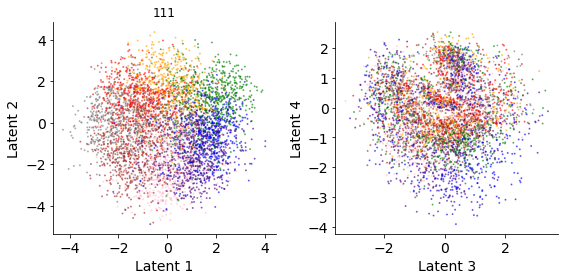

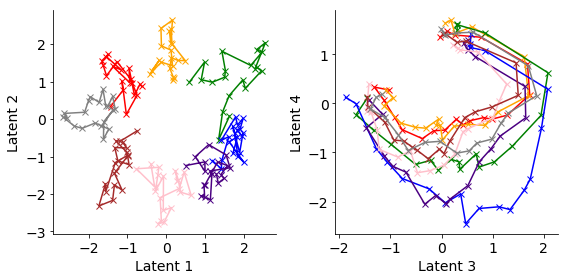

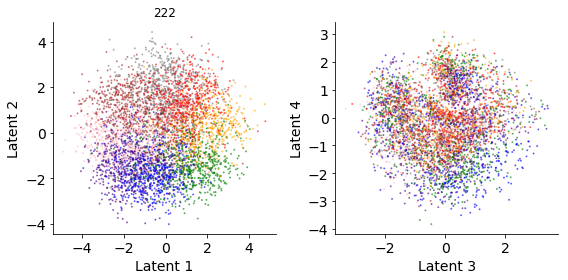

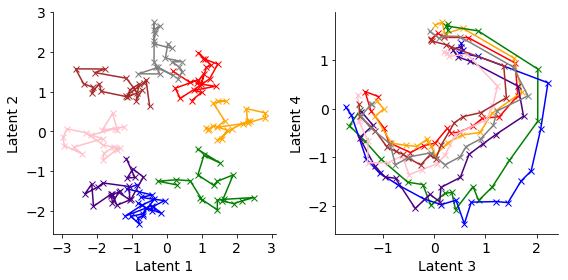

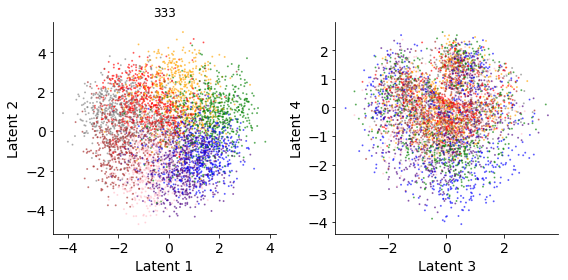

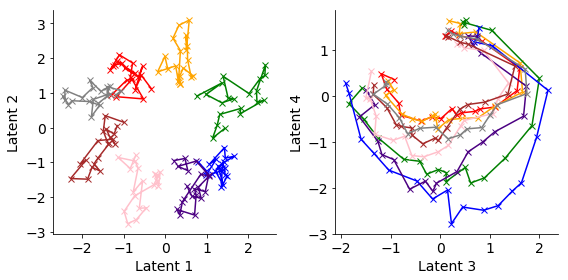

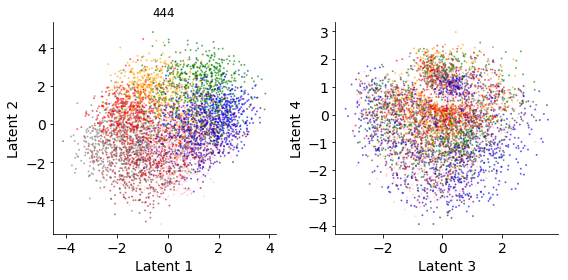

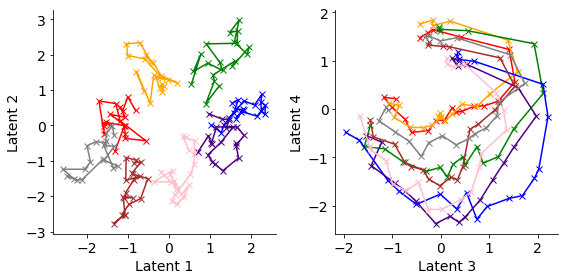

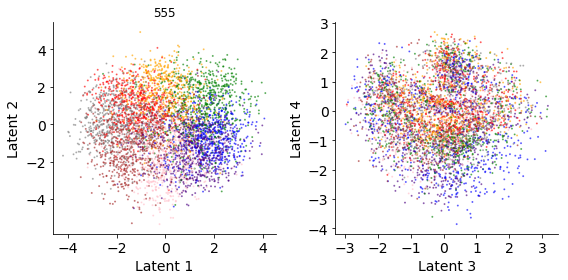

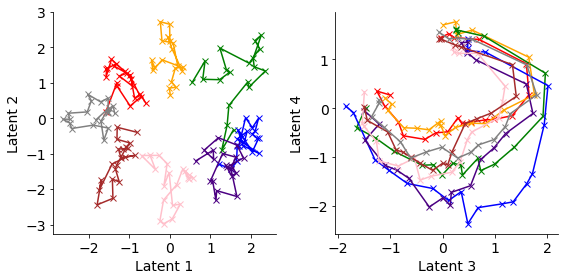

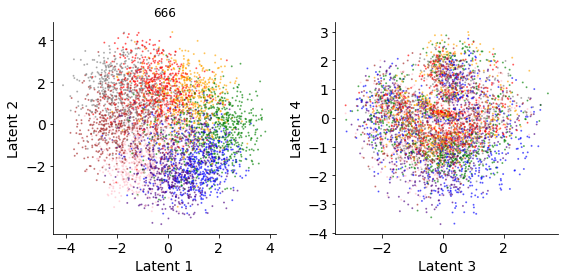

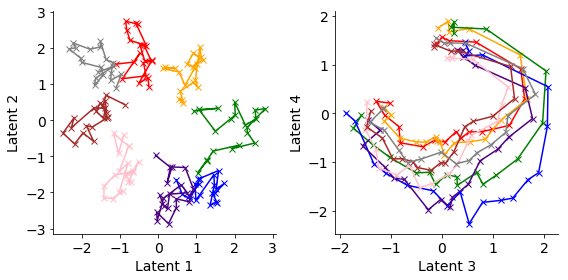

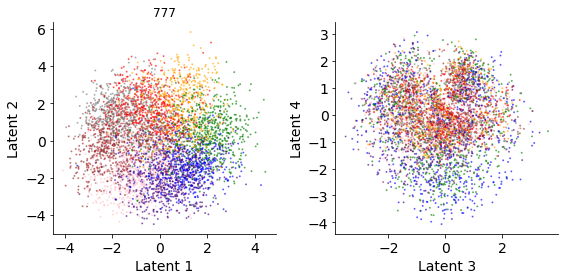

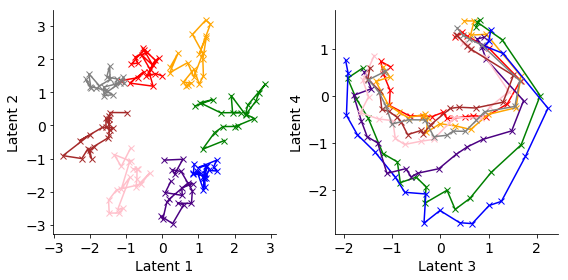

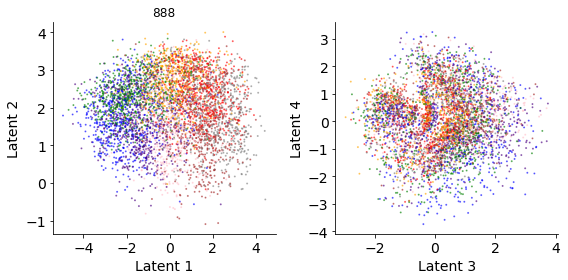

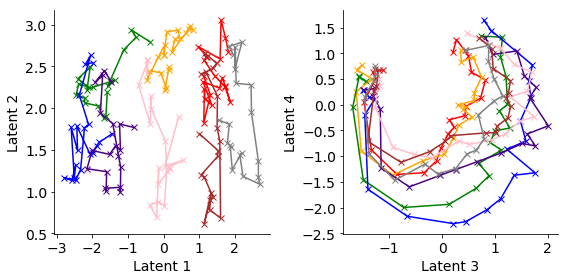

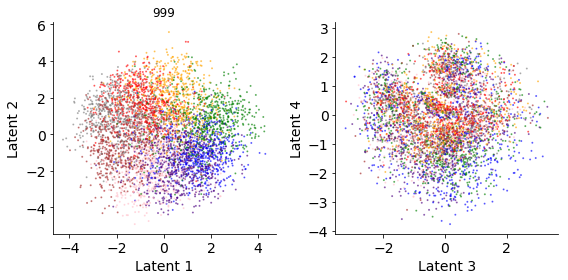

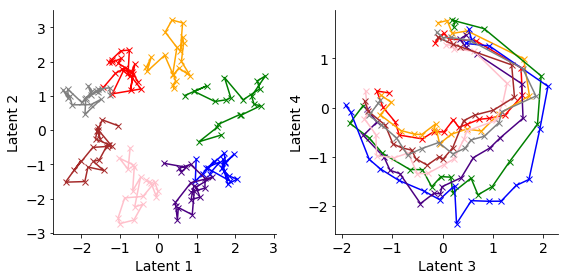

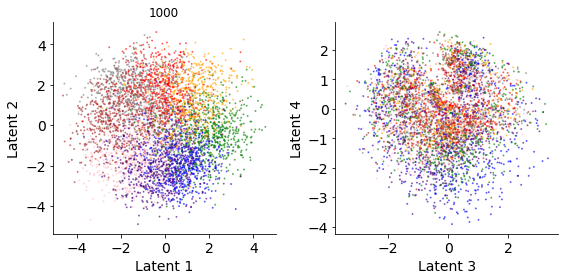

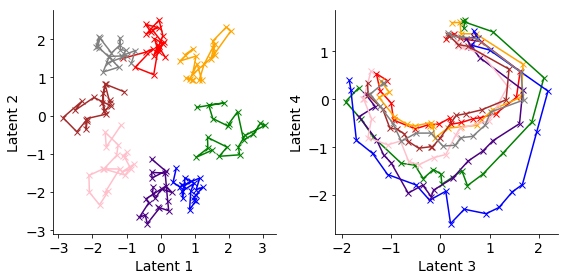

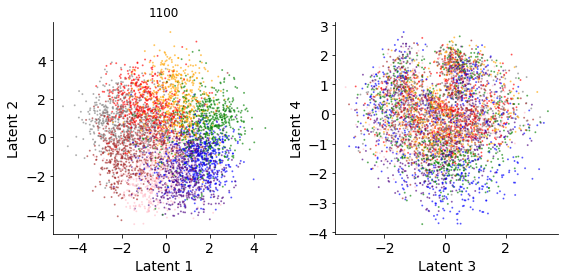

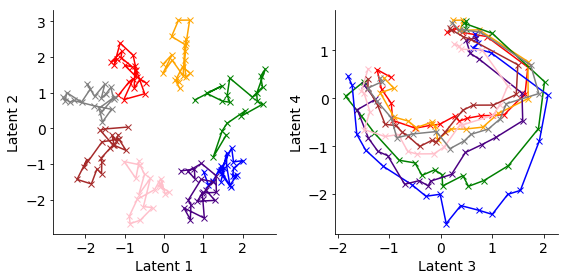

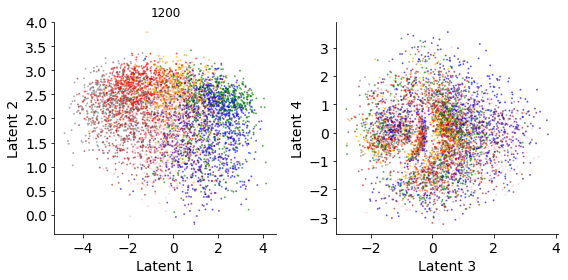

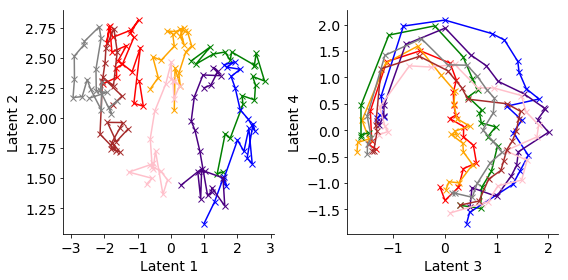

In [12]:
seed_vec = [111,222,333,444,555,666,777,888,999,1000,1100,1200]
for i in range(len(seed_vec)):
    seed_use = seed_vec[i]
    np.random.seed(seed_use);
    first_pair = [3,1]
    second_pair = [2,0]
    if seed_use == 888 or seed_use == 1200:
        first_pair = [1,2]
        second_pair = [3,0]
        
    model_chk_path = '../results/macaque_4d_'+str(seed_use)+'_pivae.h5' ##999, 777
    vae.load_weights(model_chk_path);
    outputs = vae.predict_generator(custom_data_generator(x_all, u_all),
                                                steps = len(x_all));

    z_pred_all = [];
    for ii in range(dat_all.shape[0]):
        z_pred_tmp = [];
        for jj in range(dat_all[ii].shape[0]):
            z_pred_tmp.append(vae.predict([dat_all[ii][jj], np.ones((dat_all[ii][jj].shape[0],1))*(ii)])[6]);
        z_pred_all.append(z_pred_tmp);
    z_pred_all = np.array(z_pred_all);
    
    ## posterior mean w/o prior

    c_vec = np.array(['red','orange','green','blue','indigo','pink','brown','gray'])
    c_all = np.array(np.concatenate(u_all).reshape(-1), dtype='int');

    #link = {0:0,1:1,2:3};
    #link = {0:3,1:1,2:2};
    fsz = 14;

    fig = plt.figure(figsize=(8,4))

    ax1 = plt.subplot(1,2,1);
    ax1.set_title(seed_use)
    ax1.set_xlabel('Latent 1',fontsize=fsz,fontweight='normal');
    ax1.set_ylabel('Latent 2',fontsize=fsz,fontweight='normal');
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    plt.scatter(outputs[6][:,first_pair[0]], outputs[6][:,first_pair[1]], s=1, c=c_vec[c_all%8], alpha=0.5);
    plt.setp(ax1.get_xticklabels(), fontsize=fsz);
    plt.setp(ax1.get_yticklabels(), fontsize=fsz);

    ax2 = plt.subplot(1,2,2);
    ax2.set_xlabel('Latent 3',fontsize=fsz,fontweight='normal');
    ax2.set_ylabel('Latent 4',fontsize=fsz,fontweight='normal');
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    plt.scatter(outputs[6][:,second_pair[0]], outputs[6][:,second_pair[1]], s=1, c=c_vec[c_all%8], alpha=0.5);
    plt.setp(ax2.get_xticklabels(), fontsize=fsz);
    plt.setp(ax2.get_yticklabels(), fontsize=fsz);

    plt.tight_layout()
    
    ## posterior mean w/o prior average accross trials/repeats
    c_vec = np.array(['red','orange','green','blue','indigo','pink','brown','gray'])
    c_all = np.array(np.concatenate(u_all).reshape(-1), dtype='int');

    #ndim = 2;
    #ndir = 0;
    #select = (np.concatenate(u_all).reshape(-1) == ndir);
    fig = plt.figure(figsize=(8,4))
    ax1 = plt.subplot(1,2,1);
    ax1.set_xlabel('Latent 1',fontsize=fsz,fontweight='normal');
    ax1.set_ylabel('Latent 2',fontsize=fsz,fontweight='normal');
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)

    for ndir in range(8):
        mean1 = mean2 = 0;
        n_tr = len(z_pred_all[ndir]);
        counter = 0;
        for ii in range(n_tr):
            if len(z_pred_all[ndir][ii]) >= 20:
                counter += 1;
                mean1 += z_pred_all[ndir][ii][:20,first_pair[0]];
                mean2 += z_pred_all[ndir][ii][:20,first_pair[1]];
        #print(counter)
        ax1.plot(mean1/counter, mean2/counter, '-x', c=c_vec[ndir]);

    plt.setp(ax1.get_xticklabels(), fontsize=fsz);
    plt.setp(ax1.get_yticklabels(), fontsize=fsz);

    ax2 = plt.subplot(1,2,2);
    ax2.set_xlabel('Latent 3',fontsize=fsz,fontweight='normal');
    ax2.set_ylabel('Latent 4',fontsize=fsz,fontweight='normal');
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)


    for ndir in range(8):
        mean1 = mean2 = 0;
        n_tr = len(z_pred_all[ndir]);
        counter = 0;
        for ii in range(n_tr):
            if len(z_pred_all[ndir][ii]) >= 20:
                counter += 1;
                mean1 += z_pred_all[ndir][ii][:20,second_pair[0]];
                mean2 += z_pred_all[ndir][ii][:20,second_pair[1]];
        #print(counter)
        ax2.plot(mean1/counter, mean2/counter, '-x', c=c_vec[ndir]);
    plt.setp(ax2.get_xticklabels(), fontsize=fsz);
    plt.setp(ax2.get_yticklabels(), fontsize=fsz);

    plt.tight_layout()